### 필요한 라이브러리 Import

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from konlpy.tag import Mecab

import re
import os
import io
import time
import random

from collections import Counter
import gensim

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 데이터 확인 및 전처리

In [3]:
file_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'

df = pd.read_csv(file_path)
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
df.duplicated().value_counts()

False    11823
dtype: int64

* 중복값이 없어 그대로 진행하겠습니다.

In [5]:
def corpus_len(df):
    corpus_q_len = [len(token.split()) for token in df["Q"]]
    corpus_a_len = [len(token.split()) for token in df["A"]]
    return corpus_q_len, corpus_a_len

In [6]:
corpus_q_len, corpus_a_len = corpus_len(df)

* 데이터 시각화

In [7]:
def show_data(num_tokens):
    num_tokens = np.array(num_tokens)
    
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 최소 : ', np.min(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))
    
    max_len = np.max(num_tokens)
    
    plt.hist(num_tokens, bins = max_len, range=[0, max_len], facecolor='b')
    plt.show()


문장길이 평균 :  3.587414361837097
문장길이 최대 :  15
문장길이 최소 :  1
문장길이 표준편차 :  1.6188281321513895


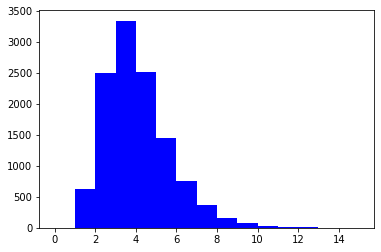

In [8]:
show_data(corpus_q_len)

문장길이 평균 :  3.6936479742874058
문장길이 최대 :  21
문장길이 최소 :  1
문장길이 표준편차 :  1.8572136133798673


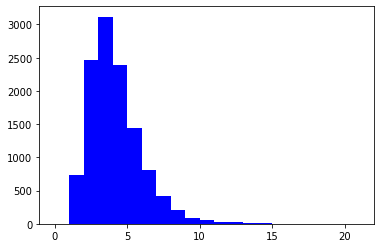

In [9]:
show_data(corpus_a_len)

* 데이터량이 적어 전체 데이터를 다 사용하겠습니다.

* 전처리

In [9]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [10]:
df["Q"] = df["Q"].apply(preprocess_sentence)
df["A"] = df["A"].apply(preprocess_sentence)
df.head()

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,ppl 심하네,눈살이 찌푸려지죠 .,0


* 토큰화

In [11]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    cleaned_corpus = []
    
    m = Mecab()
        
    for sen in corpus:
        cleaned_corpus.append(m.morphs(sen))
        
    tokenizer.fit_on_texts(cleaned_corpus)
    
    tensor = tokenizer.texts_to_sequences(cleaned_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer, cleaned_corpus

In [12]:
q_tensor, q_tokenizer, que_corpus = tokenize(df["Q"])
a_tensor, a_tokenizer, ans_corpus = tokenize(df["A"])

* Word2Vec 다운로드 및 확인

In [13]:
ko_bin_path = os.getenv("HOME")+'/aiffel/transformer_chatbot/data/ko.bin'

wv = gensim.models.Word2Vec.load(ko_bin_path)

In [14]:
wv.most_similar("강아지")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

* 데이터 부풀리기

In [15]:
def lexical_sub(sentence, word2vec):
    import random
    
    res = ""
    toks = sentence
    
    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [16]:
new_q_corpus = []
new_a_corpus = []

for idx in tqdm_notebook(range(len(que_corpus))):
    new_q_src = lexical_sub(que_corpus[idx], wv)
    a = ans_corpus[idx]
    
    if new_q_src is not None:
        new_q_corpus.append(new_q_src.split())
        new_a_corpus.append(a)
        
for idx in tqdm_notebook(range(len(ans_corpus))):
    q = que_corpus[idx]
    new_a_src = lexical_sub(ans_corpus[idx], wv)
    
    if new_a_src is not None:
        new_q_corpus.append(q)
        new_a_corpus.append(new_a_src.split())
        
print(new_q_corpus[5555])
print('-'*100)
print(new_a_corpus[5555])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/11823 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/11823 [00:00<?, ?it/s]

['상대', '가', '바람', '펴', '서', '헤어진지', '1', '년', '그러', '지났', '습니다']
----------------------------------------------------------------------------------------------------
['그런', '재', '활용', '도', '안', '되', '는', '사람', '은', '이제', '버리', '세요', '.']


* 약 2만개의 데이터를 생성했습니다.

In [17]:
print(len(new_q_corpus))
print(len(new_a_corpus))

20554
20554


* 기존 데이터와 통합

In [18]:
que_corpus = que_corpus + new_q_corpus
ans_corpus = ans_corpus + new_a_corpus

print(len(que_corpus))
print(len(ans_corpus))

32377
32377


In [19]:
tgt_corpus = []

for corpus in ans_corpus:
    tgt_corpus.append(["<start>"] + corpus + ["<end>"])
    
print(len(tgt_corpus))

ans_corpus = tgt_corpus

32377


In [20]:
q_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
q_tokenizer.fit_on_texts(que_corpus)

a_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
a_tokenizer.fit_on_texts(ans_corpus)

* 단어장 크기 확인

In [21]:
print(len(q_tokenizer.word_index))
print(len(a_tokenizer.word_index))

6224
4590


In [22]:
voc_corpus = que_corpus + ans_corpus

words = np.concatenate(voc_corpus).tolist()
counter = Counter(words)
counter = counter.most_common(10000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

* 총 단어장 크기 확인

In [23]:
print(len(word_to_index))

7942


In [24]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    a = list(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence)
    b = []
    for i in a:
        if i != '<pad>':
            b.append(i)
    
    return ' '.join(b)

In [25]:
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

que_train = vectorize(que_corpus, word_to_index)
ans_train = vectorize(ans_corpus, word_to_index)

In [26]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(que_train, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(ans_train, padding='post')

* 데이터셋 분리

In [27]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

### 모델 설계

In [28]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [29]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [30]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [31]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [32]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [33]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [34]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [35]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [37]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

* 모델 파라미터 설정

In [38]:
VOCAB_SIZE = len(word_to_index)

transformer = Transformer(
    n_layers=1,
    d_model=256,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

d_model = 256

In [39]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [40]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [41]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

* 번역 함수 정의

In [42]:
def evaluate(sentence, model):
    pieces = mecab.morphs(sentence)
    
    tokens = []
    for sen in pieces:
        sen= get_encoded_sentence(sen, word_to_index)
        tokens.append(sen)
    

    _input = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                        value=word_to_index["<pad>"],
                                                        padding='post')
    
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [43]:
def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)

    return result

* BLEU 스코어 확인

In [44]:
def eval_bleu(src_corpus, tgt_corpus, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm_notebook(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]

        src_sentence = get_decoded_sentence(src_tokens.tolist(), index_to_word) 
        tgt_sentence = get_decoded_sentence(tgt_tokens.tolist(), index_to_word)
        
        reference = preprocess_sentence(tgt_sentence).split()
        src_sentence = preprocess_sentence(src_sentence)
        candidate = translate(src_sentence, transformer).split()

        score = sentence_bleu([reference[1:-1]], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", candidate)
            print("Real: ", reference[1:-1])
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score: %.4f" % (total_score / sample_size))

* 예문

In [45]:
examples = ["지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."]

### 학습

In [46]:
# 훈련시키기

BATCH_SIZE = 64
EPOCHS = 100

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    mecab = Mecab()
    print("Epoch :", epoch+1)
    print('-'*120)
    for sentence in examples:
        print("source:", sentence)
        print("answered:", translate(sentence, transformer))
        print('-'*120)
        
    eval_bleu(enc_val, dec_val, verbose=False)
    print('-'*120)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 1
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 많이 힘들 겠 지만 마음 이 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 좋 은 더 좋 은 더 좋 은 걸 더 좋 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 저 도 힘들 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 저 도 즐거워요
------------------------------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0306
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 2
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 하 는 사람 이 니까 착각 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 이별 을 잘 하 는 것 도 좋 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 사랑 하 는 사람 이 필요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 모처럼 만 보 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0297
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 3
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 궁금 하 고 오 는 것 도 궁금 할 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 잘 놀드 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 군대 이 에요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 자고 집 마련 이 났 잖아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0344
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 4
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 그 사람 만 의 시간 도 그 사람 이 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 좋 은데 결정 을 조금 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 타이밍 이 안 맞 길 바랄게요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0310
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 5
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 지금 은 그렇게 만들 어 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에서 도 집 에서 집 마련 이 집 에서 집 에서 집 에서 조심히 집 에서 조심히 집
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0304
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 6
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 행복 하 길 바랄게요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 어떤 선택 이 든 그 가 좋 은 사람 이 겠 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 실례 같 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0345
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 7
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 궁금 하 고 오 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 있 다면 후회 만 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 그렇게 할 수 있 겠 고 싶 은 게 생길 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0291
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 8
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 이유 는 않 는 않 는 게 좋 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 하 지 않 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 그렇게 하 게 엄청 많 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 맘 같 지 않 맘 같 집 맘 같 맘 같 맘 같 맘 같 집 같 맘 같 집 같 맘 같 맘 같 맘 같 집 같 집 같 집 같 집 같 집 같 맘 같 집 같 맘
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0358
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 9
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 지금 은 그렇게 판단 이 에요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0336
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 10
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 싶 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 지금 은 그렇게 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0325
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 11
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 싶 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 만 있 다면 후회 가 되 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 엄청 대로 사세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 있 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0319
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 12
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 싶 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 후회 가 후회 가 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 태어난 그 에 도 충분히 좋 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 나 들 이 집 에서 살 집 에서 집 에서 집 에서 집 에서 드려요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0281
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 13
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 상대방 이 가 는 편 이 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 후회 가 후회 가 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 태어난 이유 만 을 찾아보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 내 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0301
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 14
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 태어난 그 에 만 으로 도 할 수 있 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 편하 고 싶 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0300
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 15
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 곳 으로 가 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 후회 오 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 의 변명 이 었 던 걸 수 도 없 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0309
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 16
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 상대방 이 부담 스럽 지 않 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 대로 할 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 시간 이 내 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0307
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 17
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 대로 가 는 단계 인가 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 생각 이 나 를 거 같 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0341
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 18
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 받 는 것 보다 좋 은 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 판단 이 나 도 하 게 하 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에서 같이 살 고 집 마련 이 가지 ㅂ시오 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0294
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 19
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 싶 은 대로 시키 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만이 더 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 사랑 만 은 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 가지 마요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0307
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 20
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 힘든 시간 이 었 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 생각 이 나 를 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0332
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 21
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 기 는 휴식 이 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 자신 을 알 다가 도 모르 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 들 이 같이 살 편하 가지 고 싶 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0317
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 22
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 편 이 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 편하 고 싶 은 사람 이 들 이 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0355
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 23
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 기 는 못하 은 항상 사랑 이 내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 시작 이 되 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0312
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 24
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 으면 좋 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 어떤 이별 이 든 후폭풍 이 필요 하 겠 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0280
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 25
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 이에 는 편 이 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 생각 만 하 지 말 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 들 이 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0363
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 26
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 싶 은 일 에 는 것 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 었 는지 후회 가 되 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 경험 이 되 지 도 몰라요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0290
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 27
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 바로 바로 바로 바로 바로 바로 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 었 는지 확인 해 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분 한 대화 를 나눠 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 편 이 좋 겠 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0306
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 28
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 사랑 하 고 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 하 기 전 에 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 당신 의 삶 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 편하 고 집 마련 이 편하 집 이 편하 겠 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0334
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 29
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 그렇게 하 게 하 게 하 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0353
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 30
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 것 이 에요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 되 었 다니 감사 합니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0303
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 31
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 편 이 좋 겠 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 안 됐 었 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은데 아직 도 당신 의 삶 이 은데 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 곁 에 같이 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0310
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 32
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 하 지 마요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 어떤 이별 이 든 후폭풍 이 필요 하 겠 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0289
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 33
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 에 는 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 힘들 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 편하 고 싶 나 집 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0322
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 34
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 것 만 판단 이 나 봐요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분히 스스로 도 당신 의 매력 을 가져 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0313
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 35
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 좋 는 것 이 에요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 후회 안 해도
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 어떤 이별 이 든 당신 의 으세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0314
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 36
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 것 도 좋 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 조심히 오 세요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0336
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 37
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 이에 는 답 이 있 길 바라 요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 되 기 후회 가 되 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0245
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 38
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 것 도 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 를 충분히 스스로 를 만들 어 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 편하 고 싶 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0281
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 39
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 내 는 것 도 좋 을 거 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 당신 의 감정 을 주 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0305
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 40
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 사랑 에 놀드 는 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분히 스스로 도 충분히 좋 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 편하 고 살 고 살 이 편하 집 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0268
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 41
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 중요 해요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 같 지 않 이 집 도 있 잖아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0285
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 42
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 이에 는 것 만 있 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에서 도 좋 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0306
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 43
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 사랑 이 라고 생각 해요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 안 되 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 없 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 같 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0273
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 44
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 것 만 나 봐요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은 사람 만날 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0329
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 45
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 보다 좋 은 방법 이 있 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 가지 고 싶 가지 도 편하 싶 은 사람 이 만나 실 거 예요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0262
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 46
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 내 가 고 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 안 되 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0300
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 47
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 만 어렵 지 않 아요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 없 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 도 집 이 도 있 잖아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0286
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 48
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 것 도 못하 이 에요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은데 사람 만날 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 편하 고 집 도 집 도 집 도 집 도 있 고 집 도 집 도 집 도 집 도 있 집 도 집 도 집 도 집 도 집 도 집 도 집 도 집 도 좋 도
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0273
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 49
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 결정 을 가 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 당신 의 삶 은 시작 해 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 편하 으시 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0303
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 50
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 는 것 도 사랑 이 에요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분히 스스로 도 좋 은 사람 만날 것 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 도 편하 고 싶 나 도 사람 이 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0284
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 51
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0327
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 52
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 확신 이 어렵 겠 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 도 충분 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 최고 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0368
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 53
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 사랑 이 에요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 남 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 슬퍼하 고 다시 하 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 같 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0307
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 54
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0315
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 55
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 데 는 시간 이 자주 힘들 어 놀드 세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 들 때 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0283
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 56
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 사랑 그러 만들 어서
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 도 안 되 고 살 이 들 에게 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0265
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 57
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 것 도 존중 방법 도 좋 겠 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0274
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 58
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 이에 못가 궁금 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 나 나 봅니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0318
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 59
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 이에 협조 받 ㄴ다는 것 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 들 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 들 이 들 과 연락 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0284
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 60
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 것 도 좋 을 것 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0242
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 61
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 없 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 도움 이 되 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0350
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 62
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 마세요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 있 었 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 하 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0321
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 63
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 후회 만 남 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 그럴 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 맘 도 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0289
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 64
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 후회 만 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 곁 에서 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0302
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 65
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 것 도 있 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 그럴 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0271
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 66
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 후회 만 남 았 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 은 자신 을 충분히 스스로 에게 좋 은 사람 은 게 사세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 마련 이 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0317
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 67
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: ㄴ다는 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 후회 만 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 옆 에 없 은 사람 이 다 고 자신 에게 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 있 잖아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0290
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 68
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 이에 많이 힘들 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 남 았 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은데 충분히 스스로 에게 좋 은 사람 에게 좋 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 가지 마요 . 같이 살 고 집 마련 이 들 게 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0284
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 69
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 그러 으며 살펴보 세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 남 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 사람 이 곁 에 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0260
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 70
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 그러 으며 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 만 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0289
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 71
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 있 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 들 선 이 바랍니다 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0265
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 72
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 ㄴ다는 것 도 좋 죠 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 도 같 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0276
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 73
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0309
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 74
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 당신 은 사람 을 다 하 게 하 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 들 때 도 있 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0367
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 75
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 했 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 지 않 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 없 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 집 마련 이 들 게 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0300
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 76
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 있 는데요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 사람 들 이 살 고 싶 은 사람 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0252
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 77
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 을 거 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 나 나 봅니다 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 이 집 이 집 이 집 이 집 이 집 에서 집 이 집 이 집 에서 조심히 집 에서 시간 이 들 과 같이 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0305
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 78
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 했 던 일 이 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 았 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 없 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 마련 이 들 과 같이 살 러 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0264
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 79
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 은 자신 을 다 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 들 선 이 들 선 톡 이 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0298
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 80
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 잊 는 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 나 봐요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 그럴 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 연인 들 과 함께 살 러 가 는 건 어떨까 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0245
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 81
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 를 내 ㅂ시오 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 도 있 시간 이 집 마련 이 들 이 같이 살 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0300
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 82
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 시키 면 던 만큼 아픔 도 있 어요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 도 조심히 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0270
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 83
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 를 많이 마세요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 한 시간 이 집 마련 이 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0307
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 84
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 없 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에서 쉬 는 시간 도 집 마련 이 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0261
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 85
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 것 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 그럴 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 들 과 같이 살 러 가 도 집 마련 이 들 선 에서 집 도 좋 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0289
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 86
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 하 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 도 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 이 집 이 집 이 집 이 집 에서 도 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0332
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 87
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 사랑 했 던 만큼 아픔 을 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 집 마련 이 들 과 시간 이 집 마련 이 집 마련 이 집 마련 이 집 사람 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0302
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 88
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 놀드 힘든 것 예요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 도 살 고 살 고 살 고 나가 요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0273
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 89
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 시키 고 있 는데요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 집 마련 이 지요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0276
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 90
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 많이 힘들 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 버텨 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 나 집 에 도 안 고 살 고 싶 다고 연락 하 는 게 좋 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0290
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 91
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 싶 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은 사람 에게 좋 은 사람 은 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 한 집 마련 이 집 마련 이 집 에 도 도움 이 돼요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0280
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 92
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 기에 싶 는데요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 마련 이 들 이 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0287
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 93
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 고 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 가 후회 만 더 힘들 지요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 에게 도 충분히 스스로 에게 때문 좋 아요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 에 도움 이 바랍니다 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0276
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 94
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 나이 는 중요 해요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 았 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 좋 은 사람 과 걱정 은 자신 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 집 마련 이 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0250
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 95
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 느낌 이길 바 라요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 좋 은 사람 과 걱정 은 하 지 않 지만 , 이제 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0299
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 96
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 는데요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 았 네요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 집 마련 이 죠 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0263
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 97
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 바로 을 자주 몰라요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 남 을 거 예요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 만 은 충분히 스스로 에게 좋 은 방법 이 다
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 집 마련 이 들 어 집 마련 이 에요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0372
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 98
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 어 가 는 것 도 중요 해요 .
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 조금 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 같이 살 고 싶 은 시간 이 있 나 봐요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0340
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 99
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 는 어서 플 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 힘내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분히 스스로 극복 할 수 있 어요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 마련 이 고 살 고 살 고 살 고 싶 은 사람 이 길 바랍니다 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0275
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 100
------------------------------------------------------------------------------------------------------------------------
source: 지루하다, 놀러가고 싶어.
answered: 안타깝 지요 는데
------------------------------------------------------------------------------------------------------------------------
source: 오늘 일찍 일어났더니 피곤하다.
answered: 후회 만 더 보내 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 간만에 여자친구랑 데이트 하기로 했어.
answered: 충분 한 대화 를 나눠 보 세요 .
------------------------------------------------------------------------------------------------------------------------
source: 집에 있는다는 소리야.
answered: 집 이 고 집 에서 살 고 싶 고 싶 나 분위기 도 안 도 좋 아요 .
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/324 [00:00<?, ?it/s]

Num of Sample: 324
Total Score: 0.0253
------------------------------------------------------------------------------------------------------------------------


* 에폭당 예문 답변과 BLEU 스코어를 출력해 보았습니다.

### 회고
* 처음 학습때 &#60;unk&#62; 토큰이 너무 많이 생성되었습니다. 이유는 단어의 개수를 단어장보다 많이 생성해서 &#60;unk&#62;가 생성된것 같았습니다.
* 두번째는 번역이 제대로 이루어지지 않았습니다. 임베딩 과정에서 쓰는 word_to_index를 mecab에서 자동으로 바꿔주는걸 썼다가 원문 복원때 다른 index_to_word를 사용해서 그랬고 전처리 과정을 동일한 word_to_index와 index_to_word를 사용하니 해결됐습니다.
* 과적합을 피하기 위해 파라미터를 수정했습니다. 하지만 에폭이 평균적으로 80번을 넘으면 과적합이 일어나는것 같아 모델을 사용하려면 에폭수를 낮춰 다시 학습하면 될것 같습니다. 마지막으로 BLEU 스코어는 4%를 넘지 못해 아쉽지만 학습과정중 제대로된 답변을 보면 신기했습니다.